# Прогнозирование оттока клиентов фитнес-центра

## Описание проекта

### Цель
Повысить удержание клиентов сети фитнес-центров путём разработки стратегии взаимодействия с клиентами на основе аналитических данных.

### Описание данных
csv-файл содержащий данные клиента за предыдущий до проверки факта оттока месяц, информацию на основе журнала посещений, покупок и информацию о текущем статусе абонемента клиента:
- `gender` — пол;
- `Near_Location` — проживание или работа в районе, где находится фитнес-центр;
- `Partner` — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент (в таком случае фитнес-центр хранит информацию о работодателе клиента));
- `Promo_friends` — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
- `Phone` — наличие контактного телефона;
- `Age` — возраст;
- `Lifetime` — время с момента первого обращения в фитнес-центр (в месяцах);
- `Contract_period` — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
- `Month_to_end_contract` — срок до окончания текущего действующего абонемента (в месяцах);
- `Group_visits` — факт посещения групповых занятий;
- `Avg_class_frequency_total` — средняя частота посещений в неделю за все время с начала действия абонемента;
- `Avg_class_frequency_current_month` — средняя частота посещений в неделю за предыдущий месяц;
- `Avg_additional_charges_total` — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон;
- `Churn` — факт оттока в текущем месяце.

### Ход выполнения
1. Исследовательский анализ данных (EDA).
2. Построение модели бинарной классификации оттока клиентов (классификационный признак факт оттока).
3. Кластеризация клиентов.
4. Формулировка выводов и базовых рекомендаций по работе с клиентами.

## Загрузка данных

In [1]:
#импортирование библиотек
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
pd.set_option('display.float_format', '{:,.2f}'.format)

In [2]:
df = pd.read_csv('/datasets/gym_churn.csv') #загрузка датафрейма

## Исследовательский анализ данных (EDA)

### Общие сведения о данных

In [3]:
def information(df): #функция для получения общих сведений о датафрейме
    print('\033[1m' + 'Типы данных:' + '\033[0m')
    display(df.dtypes)
    print('\033[1m' + 'Первые 2 строки:' + '\033[0m')
    display(df.head(2))
    print('\033[1m' + 'Количество столбцов в датафрейме:' + '\033[0m', len(df.columns))
    print('\033[1m' + 'Количество строк в датафрейме:' + '\033[0m', len(df))
    print('\033[1m' + 'Количество дубликатов:' + '\033[0m', df.duplicated().sum())
    print('\033[1m' + 'Количество пропусков:' + '\033[0m')
    display(df.isna().sum())
    print('\033[1m' + 'Доля пропусков:' + '\033[0m')
    print(df.isna().sum() / len(df.index))

In [4]:
information(df)

Типы данных:


gender                                 int64
Near_Location                          int64
Partner                                int64
Promo_friends                          int64
Phone                                  int64
Contract_period                        int64
Group_visits                           int64
Age                                    int64
Avg_additional_charges_total         float64
Month_to_end_contract                float64
Lifetime                               int64
Avg_class_frequency_total            float64
Avg_class_frequency_current_month    float64
Churn                                  int64
dtype: object

Первые 2 строки:


,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.23,5.00,3,0.02,0.00,0
1,0,1,0,0,1,12,1,31,113.20,12.00,7,1.92,1.91,0


Количество столбцов в датафрейме: 14
Количество строк в датафрейме: 4000
Количество дубликатов: 0
Количество пропусков:


gender                               0
Near_Location                        0
Partner                              0
Promo_friends                        0
Phone                                0
Contract_period                      0
Group_visits                         0
Age                                  0
Avg_additional_charges_total         0
Month_to_end_contract                0
Lifetime                             0
Avg_class_frequency_total            0
Avg_class_frequency_current_month    0
Churn                                0
dtype: int64

Доля пропусков:
gender                              0.00
Near_Location                       0.00
Partner                             0.00
Promo_friends                       0.00
Phone                               0.00
Contract_period                     0.00
Group_visits                        0.00
Age                                 0.00
Avg_additional_charges_total        0.00
Month_to_end_contract               0.00
Lifetime                            0.00
Avg_class_frequency_total           0.00
Avg_class_frequency_current_month   0.00
Churn                               0.00
dtype: float64


Датафрейм содержит 14 столбцов: столбец 'Churn' содержит целевую переменную указывающую на отток клиента, в оставшихся 13 столбцах содержится информация о признаках. В датафрейме 4000 тысячи записей, каждая из которых соответствует одному наблюдению. Пропуски и дубликаты отсутствуют.

Выделим целевую переменную и признаки в отдельные датафреймы.

In [5]:
X = df.drop(['Churn'], axis=1) #признаки
y = df['Churn'] #целевая переменная

In [6]:
for column in df.columns: #получение характерных значений для каждого столбца
    print('Характерные значения в столбце', column)
    display(df[column].describe().round(2))
    print()

Характерные значения в столбце gender


count   4,000.00
mean        0.51
std         0.50
min         0.00
25%         0.00
50%         1.00
75%         1.00
max         1.00
Name: gender, dtype: float64


Характерные значения в столбце Near_Location


count   4,000.00
mean        0.85
std         0.36
min         0.00
25%         1.00
50%         1.00
75%         1.00
max         1.00
Name: Near_Location, dtype: float64


Характерные значения в столбце Partner


count   4,000.00
mean        0.49
std         0.50
min         0.00
25%         0.00
50%         0.00
75%         1.00
max         1.00
Name: Partner, dtype: float64


Характерные значения в столбце Promo_friends


count   4,000.00
mean        0.31
std         0.46
min         0.00
25%         0.00
50%         0.00
75%         1.00
max         1.00
Name: Promo_friends, dtype: float64


Характерные значения в столбце Phone


count   4,000.00
mean        0.90
std         0.30
min         0.00
25%         1.00
50%         1.00
75%         1.00
max         1.00
Name: Phone, dtype: float64


Характерные значения в столбце Contract_period


count   4,000.00
mean        4.68
std         4.55
min         1.00
25%         1.00
50%         1.00
75%         6.00
max        12.00
Name: Contract_period, dtype: float64


Характерные значения в столбце Group_visits


count   4,000.00
mean        0.41
std         0.49
min         0.00
25%         0.00
50%         0.00
75%         1.00
max         1.00
Name: Group_visits, dtype: float64


Характерные значения в столбце Age


count   4,000.00
mean       29.18
std         3.26
min        18.00
25%        27.00
50%        29.00
75%        31.00
max        41.00
Name: Age, dtype: float64


Характерные значения в столбце Avg_additional_charges_total


count   4,000.00
mean      146.94
std        96.36
min         0.15
25%        68.87
50%       136.22
75%       210.95
max       552.59
Name: Avg_additional_charges_total, dtype: float64


Характерные значения в столбце Month_to_end_contract


count   4,000.00
mean        4.32
std         4.19
min         1.00
25%         1.00
50%         1.00
75%         6.00
max        12.00
Name: Month_to_end_contract, dtype: float64


Характерные значения в столбце Lifetime


count   4,000.00
mean        3.72
std         3.75
min         0.00
25%         1.00
50%         3.00
75%         5.00
max        31.00
Name: Lifetime, dtype: float64


Характерные значения в столбце Avg_class_frequency_total


count   4,000.00
mean        1.88
std         0.97
min         0.00
25%         1.18
50%         1.83
75%         2.54
max         6.02
Name: Avg_class_frequency_total, dtype: float64


Характерные значения в столбце Avg_class_frequency_current_month


count   4,000.00
mean        1.77
std         1.05
min         0.00
25%         0.96
50%         1.72
75%         2.51
max         6.15
Name: Avg_class_frequency_current_month, dtype: float64


Характерные значения в столбце Churn


count   4,000.00
mean        0.27
std         0.44
min         0.00
25%         0.00
50%         0.00
75%         1.00
max         1.00
Name: Churn, dtype: float64

- 51% клиентов имеют гендерную принадлежность обозначенную как 1 (в описании данных не указано какой пол обозначен соответствующей цифрой);
- 85% клиентов поживают или работают в районе, где расположен фитнес-центр;
- 49% клиентов являются сотрудниками компаний-партнёров клуба;
- 31% клиентов записались в рамках акции "приведи друга";
- 90% карточек клиентов содержат данные о контактном телефоне;
- большая часть клиентов имеют абонемент на 1 месяц посещений;
- 41% клиентов посещают групповые занятия;
- возраст клиентов варьируется от 18 до 41 года, средний возраст клиентов составляет 29 лет, при относительно небольшом стандартном отклонении - 3,26, т.е. данные распределены относительно компактно (небольшой разброс).
- суммарная выручка от других услуг фитнес-центра колеблется от 0,15 до 552.59 у.е., среднее значение составляет 146,94 у.е., с достаточно большим стандартным отклонением 96,36 у.е.;
- т.к. большая часть клиентов посещают фитнес-центр по месячному абонементу, то соответственно и до окончания абонемента у большей части клиентов тоже 1 месяц, среднее количество месяцев до окончания абонемента составляет 4,32, при стандартном отклонении 4,19;
- минимальное и максимальное количество месяцев с момента первого обращения составляет 0 и 31 месяц соответственно, среднее значение - 3,72, со стандартным отклонением 3,75, т.е. данные сильно рассеяны;
- средняя средней частоты посещений фитнес-центра в неделю за все время посещений составляет 1,88 (от 0 до 6,02), с высоким стандартным отклонением (0,97);
- средняя средней частоты посещений фитнес-центра в неделю за последний месяц составляет 1,77 (от 0 до 6,15), также с высоким стандартным отклонением (1,05);
- процент оттока клиентов в представленной выборке составил 27%.

### Изучение средних значений в группах пользователей (по факту оттока)

In [7]:
df.groupby('Churn').mean() #вывод средних значений признаков в разрезе групп по факту оттока

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month
Churn,,,,,,,,,,,,,
0,0.51,0.87,0.53,0.35,0.90,5.75,0.46,29.98,158.45,5.28,4.71,2.02,2.03
1,0.51,0.77,0.36,0.18,0.90,1.73,0.27,26.99,115.08,1.66,0.99,1.47,1.04


При анализе средних значений признаков а группе оттока и группе оставшихся клиентов установлено: 
- в обоих группах доля клиентов, чей гендер обозначен как 1, составляет 51%;
- в группе оттока доля клиентов проживающих или работающих в районе фитнем-клуба составляет 77%, а в группе оставшихся - 87%;
- доля клиентов, работающих в компаниях-партнёрах клуба составляет 53% и 36% в группе оставшихся и группе оттока соответственно;
- в группе оттока 18% клиентов записались в фитнес_клуб в рамках акции "приведи друга", а в группе оставшихся их доля составляет 35%;
- доля клиентов, оставивших свой контактный телефон, в обоих группах составляет 90%;
- средняя длительность абонемента в группе оттока ниже, чем в группе оставшихся - 1,73 и 5,75 соответственно;
- в группе оставшихся групповые занятия посещают 46% клиентов, в то время как в группе оттока их доля составляет только 27%;
- средний возраст клиента в группе оттока составляет 26,99, а в группе оставшихся - 29,98;
- средний показатель суммарной выручки от других услуг фитнес-клуба в группе оттока - 115,08 у.е., а в группе оставшихся - 158,45 у.е.
- среднее количество месяцев то окончания абонемента в группе оттока и группе оставшихся составляет 1,66 и 5,28 соответственно;
- среднее количество месяцев посещения после первого обращения в фитнес-центр в группе оставшихся также выше, чем в группе оттока - 4,71 и 0,99 соответственно;
- среднее значение средней частоты посещений в неделю за всё время в группе оттока составляет 1,47, а в группе оставшихся - 2,02;
- среднее значение средней частоты посещений в неделю за последний месяц составляет 1,04 в группе оттока и 2,03 в группе оттока. 

### Гистограммы распределения признаков в группе оттока и группе оставшихся

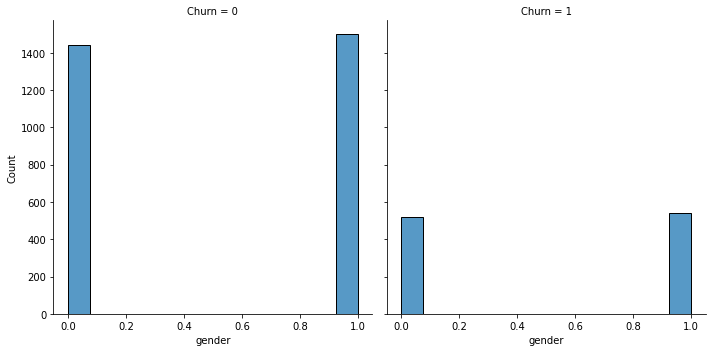

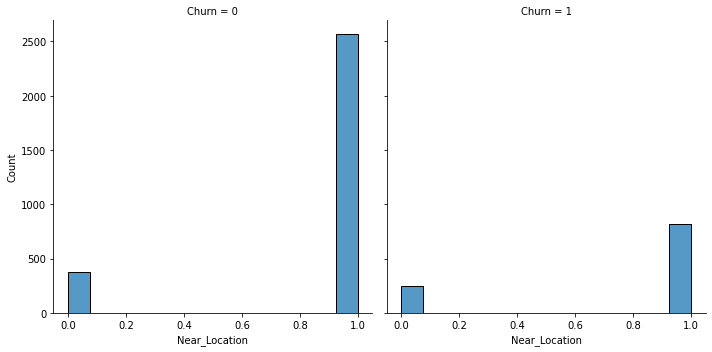

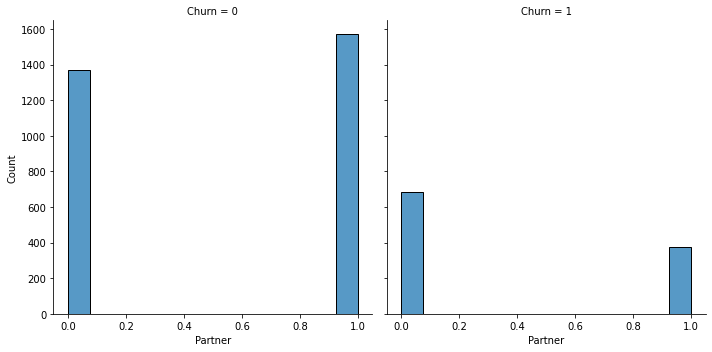

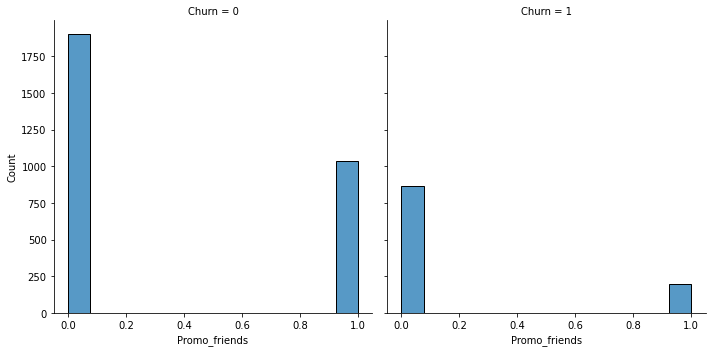

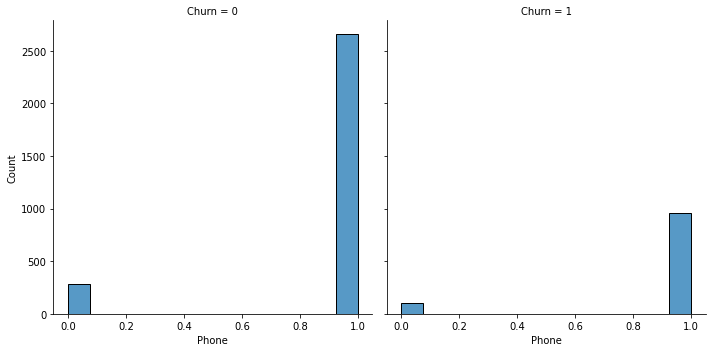

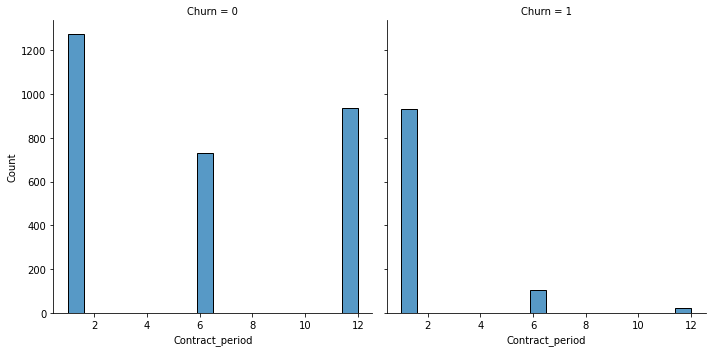

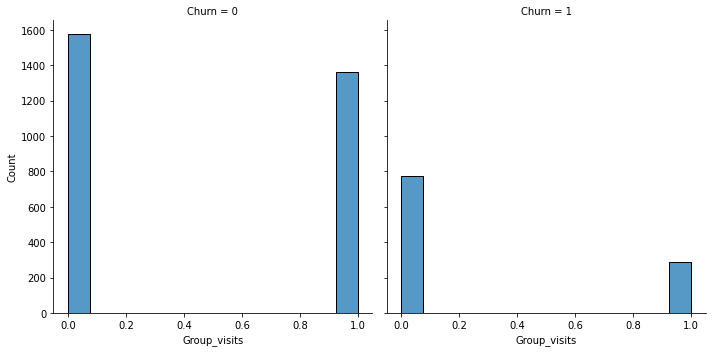

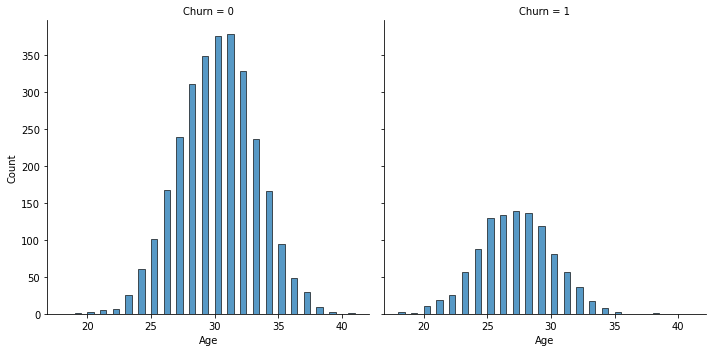

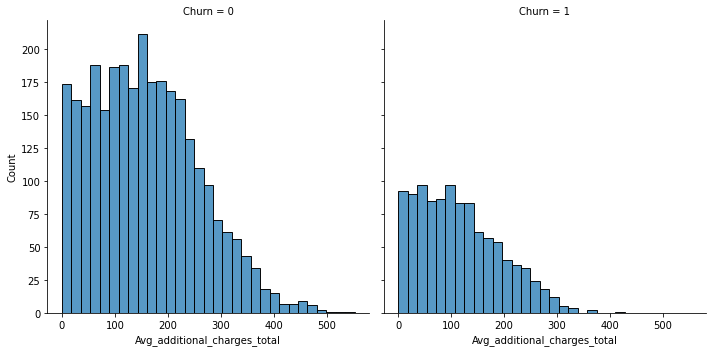

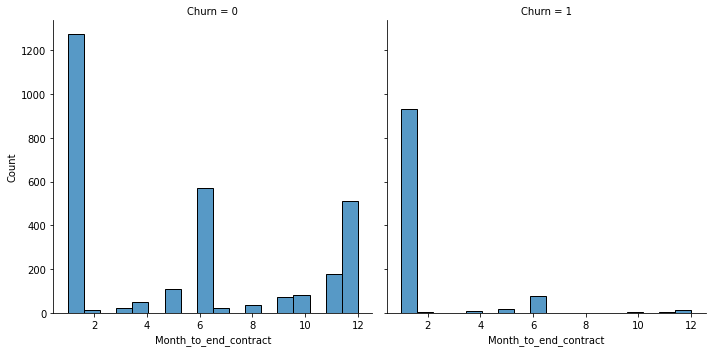

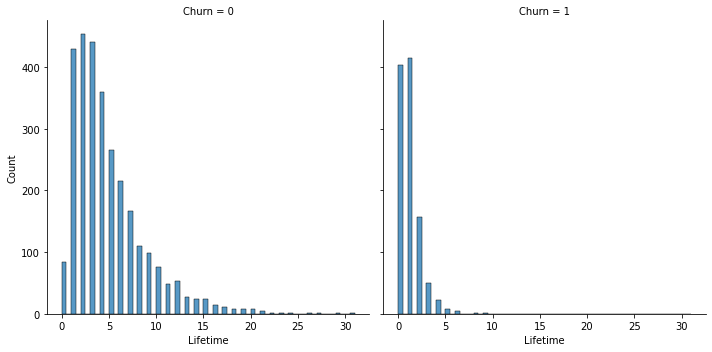

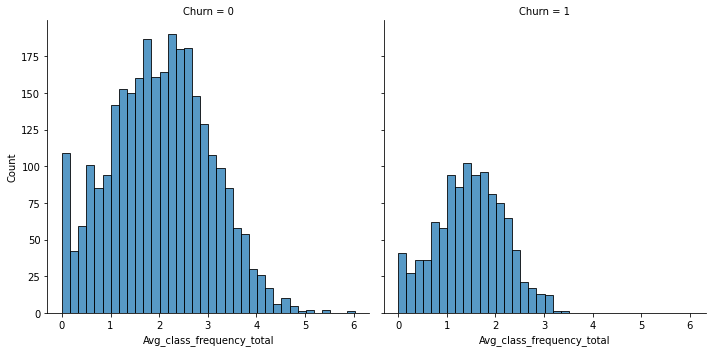

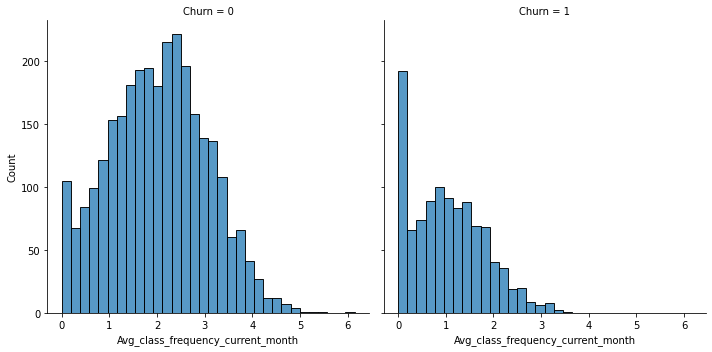

In [8]:
for column in X.columns:
    sns.displot(data=df, x=column, col='Churn')

Распределение биноминальных признаков в группах фактически уже рассмотрено выше, поэтому остановимся на распределении признаков которые могут принимать более двух значений:
- в группе оттока преобладает клиенты с абонементом на 1 месяц, в то время как в группе оставшихся клиентов более половины имеют абонементы на 6 и 12 месяцев;
- данные о возрасте клиентов в обоих группах распределены нормально, но группе оставшихся клиенты в среднем несколько старше;
- данные о суммарной выручке от других услуг фитнес-клуба в обоих группах скошены вправо, в группе оттока большая часть клиентов тратит до 100 у.е. на другие услуги и единицы тратят более 300 у.е., а вгруппе оставшихся траты большей части клиентов составляют 50-200 у.е., а некоторые клиенты тратят 400-500 у.е.;
- в группе оттока у абсолютного большинства клиентов срок до окончания текущего абонемента составляет 1 месяц, в группе оставшихся таких клиентов тоже большинство, но на ряду с этим имеется значительное количество клиентов у которых срок до окончания текущего абонемента составляет 6-12 месяцев;
- лайфтайм у основной массы клиентов в группе оттока не превышает 2 месяцев (чаще 0 или 1 месяц), а вгруппе оставшихся лайфтайм большинства клиентов составляет 1-4 месяца, значительное количество клиентов посещают фитнес-клуб в течении 5-10 месяцев, а некоторые клиенты здерживаются даже на 20 и более месяцев;
- наиболее встречаемая средняя частота посещений фитнес-клуба в неделю за всё время в группе оттока лежит в диапазоне от 1 до 2 раз, а в группе оставшихся от 1 до 3;
- наиболее встречаемая средняя частота посещений фитнес-клуба за последний месяц в группе оттока равна 0, а вгруппе оставшихся составляет 1-3 раза.

### Матрица корреляций

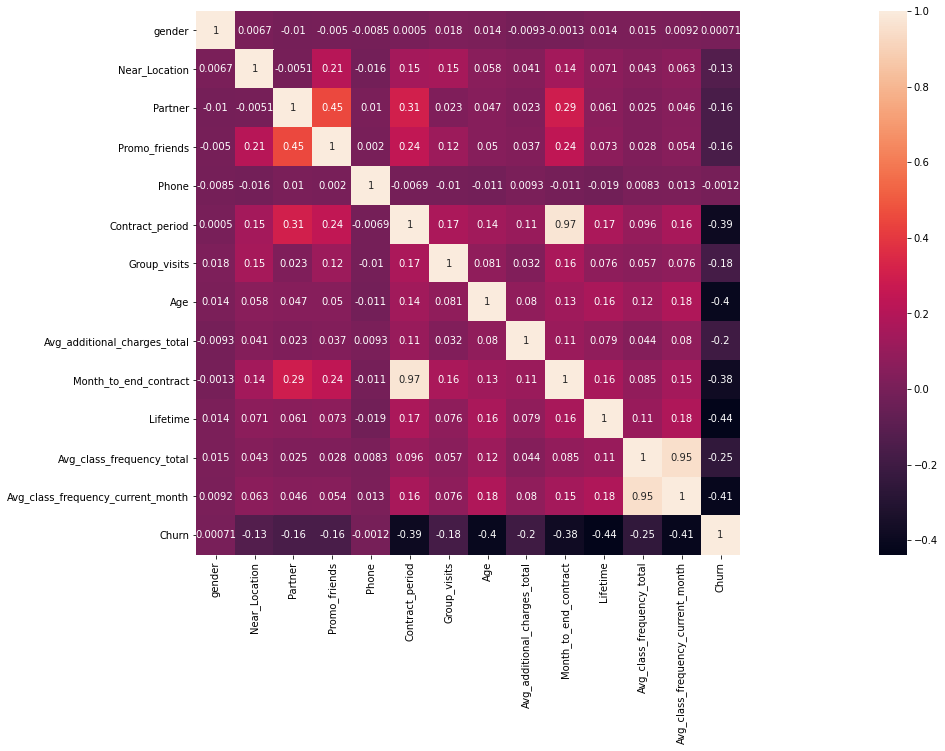

In [9]:
plt.figure(figsize=(50,10)) #построение и отражение матрицы корреляций
sns.heatmap(df.corr(), annot=True, square=True)
plt.show()

Из матрицы корреляций следует, что наблюдается:
- обратная умеренная связь (в соответствии с таблицей Чеддока) между фактом оттока и длительностью абонемента и количеством месяцев до окончания абонемента, возрастом клиента, временем с момента первого посещения фитнес-клуба и средней частотой посещений в неделю за последний месяц и за всё время;
- слабая обратная связь с фактом оттока по остальным признакам, за исключением пола и наличия телефона клиента (по данным признакам корреляция практически отсутствует);
- весьма высокая прямая связь выявлена между такими признаками, как количество месяцев до конца абонемента и длительность абонемента (0,97), средняя частота посещений фитнес-клуба в неделю за весь период и средняя частота посещений фитнес-клуба в неделю за последний месяц, т.е. данные признаки являются мультиколлинеарными.

Мультиколлинеарные признаки могут негативно влиять на работу моделей, особенно линейных, к коим относится логистическая регрессия, которую мы намерены использовать. Удалим те признаки из пары мультиколлинеарных, которые имеют менее тесную корреляцию с исходом - это количество месяцев до окончания абонемента и среднее количество посещений фитнес-центра в неделю за всё время.

In [10]:
X = X.drop(['Month_to_end_contract', 'Avg_class_frequency_total'], axis=1) #удаление признаков из мультиколлинеарных пар

### Промежуточные выводы

По результатам, проведённого EDA можно заключить следующее:
1. Данные на которых предполагается дальнейшее ML, содержат целевую переменную, которой обозначается факт оттока пользователя и 13 признаков.
2. В данных отсутствуют пропуски и дубликаты, категориальные данные в основном представлены биноминальными значениями (0, 1).
3. В группе оттока по сравнению с группой оставшихся:
- преобладают клиенты с абонементом на 1 месяц; 
- ниже доля клиентов проживающих или работающих в районе фитнес-центра, работающих в компании-партнёре, записавшихся в рамках бонусной программы, посещающих групповые занятия;
- ниже средний возраст, лайфтайм, средняя выручка от других услуг, средняя количество месяцев до окончания абонемента, средние значения средней частоты посещений в неделю за всё время и за последний месяц.
4. При построении матрицы корреляций выявлено:
- наличие обратной умеренной связи оттока клиентов с длительностью абонемента, количеством месяцев до окончания абонемента, возрастом клиента, лайфтаймом, средней частотой посещений в неделю за последний месяц и за всё время;
- наличие слабой обратной связи оттока клиентов с проживанием или работой клиента в районе фитнес-клуба, работой клиента в компании-партнёре, записью в рамках бонусной программы, посещением групповых занятий, средней выручкой от других услуг;
- весьма высокая прямая связь количества месяцев до конца абонемента с длительностью абонемента, и средней частоты посещений фитнес-клуба в неделю за весь период со средней частотой посещений фитнес-клуба в неделю за последний месяц.

## Построение модели прогнозирования оттока клиентов

### Разделение данных на обучающую и валидационную выборку

Разобъём данные на обучающую и валидационную выборки в общепринятом соотношении - 80% обучающая выборка и 20% валидационная. 

In [11]:
#получение обучающей и тестовой выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

### Обучение модели логистической регрессией

In [12]:
lr_model = LogisticRegression(solver='liblinear') #алгоритм для модели обучения
lr_model.fit(X_train, y_train) #обучение модели на обучающей выборке
lr_predictions = lr_model.predict(X_test) #прогноз модели на валидационно выборке

### Обучение модели случайным лесом

In [13]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=0) #алгоритм для модели обучения
rf_model.fit(X_train, y_train) #обучение модели на обучающей выборке
rf_predictions = rf_model.predict(X_test) #прогноз модели на валидационно выборке

### Оценка метрик и выбор наилучшей модели

In [14]:
def metrics(y, y_pred): #функция для расчёта метрик
    print('Accuracy:', accuracy_score(y, y_pred).round(2))
    print('Precision:', precision_score(y, y_pred).round(2))
    print('Recall:', recall_score(y, y_pred).round(2))

In [15]:
metrics(y_test, lr_predictions) #расчёт метрик для модели логистической регрессии

Accuracy: 0.91
Precision: 0.85
Recall: 0.82


In [16]:
metrics(y_test, rf_predictions)

Accuracy: 0.9
Precision: 0.85
Recall: 0.77


- Доля правильных ответов (Accuracy) в моделе логистической регрессии и моделе случайного леса составила 91% и 90% соответственно.
- Доля правильно спрогнозированного оттока клиентов от всего спрогнозированного оттока (Precision) в моделе логистической регрессии и моделе случайного леса составила по 85%.
- Доля правильно спрогнозированного оттока клиентов от реального оттока (Recall) в моделе логистической регрессии и моделе случайного леса составила 82% и 77% соответственно.

### Промежуточные выводы

Модель логистической регрессии показала более высокие значения метрик Accuracy и Recall, по сравнению с моделью случайного леса, а значит она лучше прогнозирует отток клиента.

## Кластеризация клиентов

### Стандартизация данных

In [17]:
scaler = StandardScaler() #создание объекта scaler
X_st = scaler.fit_transform(X) #стандартизация данных с признками

### Матрица расстояний и дендрограмма

In [18]:
linked = linkage(X_st, method='ward') #создание таблицы "связок" между объектами

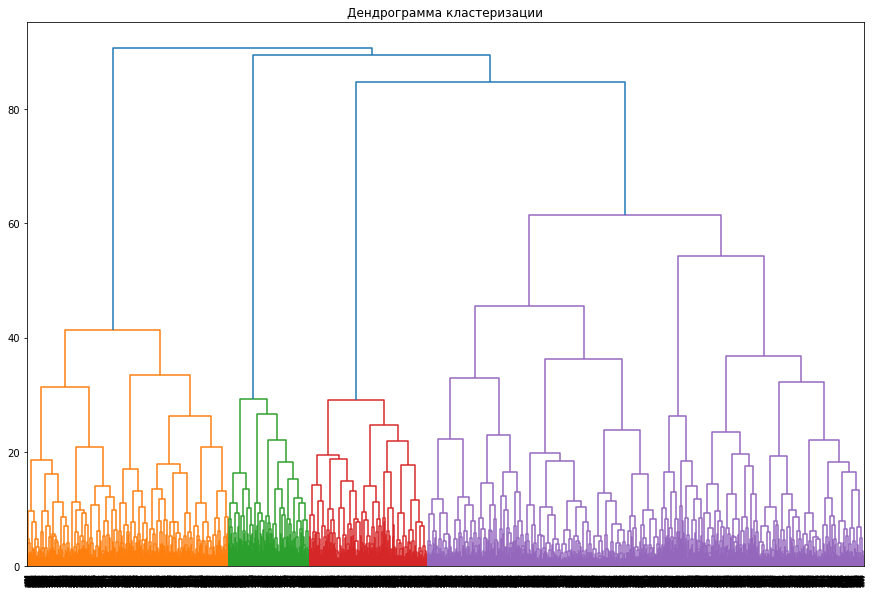

In [19]:
#отрисовка дендрограммы
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Дендрограмма кластеризации')
plt.show() 

Алгоритм предлагает в качестве оптимального количества кластеров - 4, соответствует 4 цветам, выделенным на дендрограмме.

### Прогнозирование кластеров клиентов 

In [20]:
km = KMeans(n_clusters=5, random_state=0) #алгоритм кластеризации с пятью заданными классами
labels = km.fit_predict(X_st) #применение алгоритма к стандартизированным данным о признаках
df['clusters'] = labels #добавление данных о кластерах в датафрейм

### Средние значения признаков для кластеров

In [21]:
df.groupby('clusters').mean() #рассчёт средних значений признаков для каждого кластера

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
clusters,,,,,,,,,,,,,,
0,0.50,1.00,0.89,1.00,1.00,6.92,0.52,29.61,153.42,6.33,4.28,1.96,1.92,0.12
1,0.50,0.00,0.49,0.08,1.00,2.99,0.23,28.68,137.13,2.82,2.97,1.76,1.60,0.40
2,0.50,1.00,0.22,0.07,1.00,2.01,0.28,27.58,119.34,1.94,1.92,1.45,1.20,0.56
3,0.53,1.00,0.38,0.01,1.00,6.21,0.54,30.70,176.26,5.65,5.42,2.32,2.32,0.01
4,0.52,0.86,0.47,0.31,0.00,4.78,0.43,29.30,144.21,4.47,3.94,1.85,1.72,0.27


Характеристика средних значений в полученных кластерах:
1. Кластер "0":
- самые высокие доли клиентов из компаний-партнеров (89%), привлеченных в рамках бонусной программы (100%);
- самые высокие средняя длительность абонемента (6,92 мес) и соответственно среднее количество месяцев до окончания абонемента (6,33 мес);
- высокие доля клиентов, посещающих групповые занятия (52%), средний средний возраст клиента (29,61) лайфтайм (4,28 мес), средняя выручка от других услуг (153,42 у.е.), средние значения средней частоты посещений фитнес-центра за всё время (1,96) и за последний месяц (1,92).
- относительно невысокий процент оттока (12%).
2. Кластер "1":
- в данный кластер попали все кто не проживает и не работает в районе фитнес-центра;
- самая низкая доля посещений групповых занятий (23%)
- относительно низкие, средняя длительность абонемента (2,99 мес), средняя выручка от других услуг фитнес-центра (137,13 у.е.), лайфтайм (2,97 мес), среднее значение средней частоты посещений в неделю за всё время (1,76) и последний месяц (1,60);
- процент оттока очень высокий (40%).
3. Кластер "2":
- самые низкие доли клиентов, являющихся сотрудниками компаний партнеров (22%), записавшихся в рамках бонусной программы (7%);
- самые низкие средняя длительность абонемента (2,01 мес), средний возраст клиента (27,58), средняя выручка от других услуг (119,34 у.е.), средний лайфтайм (1,92 мес), средняя частота посещений в неделю за всё время (1,45) и последний месяц (1,20);
- процент оттока самый высокий (56%).
4. Кластер "3":
- самая высокая доля клиентов, посещающих групповые занятия (54%);
- самая низкая доля клиентов, записавшихся в рамках бонусной программы (1%);
- высокие средняя длительность абонемента (6,21 мес), 
- самые высокие средний возраст клиента (30,70), средний лайфтайм (5,42 мес), средняя выручка от других услуг фитнес-центра (176,26 у.е.), средние значения средней частоты посещений фитнес-центра в неделю за всё время (2,32) и за последний месяц (2,32);
- самый низкий отток клиентов (1%).
5. Кластер "4":
- в данный кластер попали все клиенты не оставившие свой номер телефона;
- относительно высокая доля клиентов, пришедших в рамках бонусной программы (31%)
- по остальным признакам данный кластер обладает промежуточными средними значениями относительно других кластеров;
- промежуточный уровень оттока (27%).

### Распределение признаков для кластеров

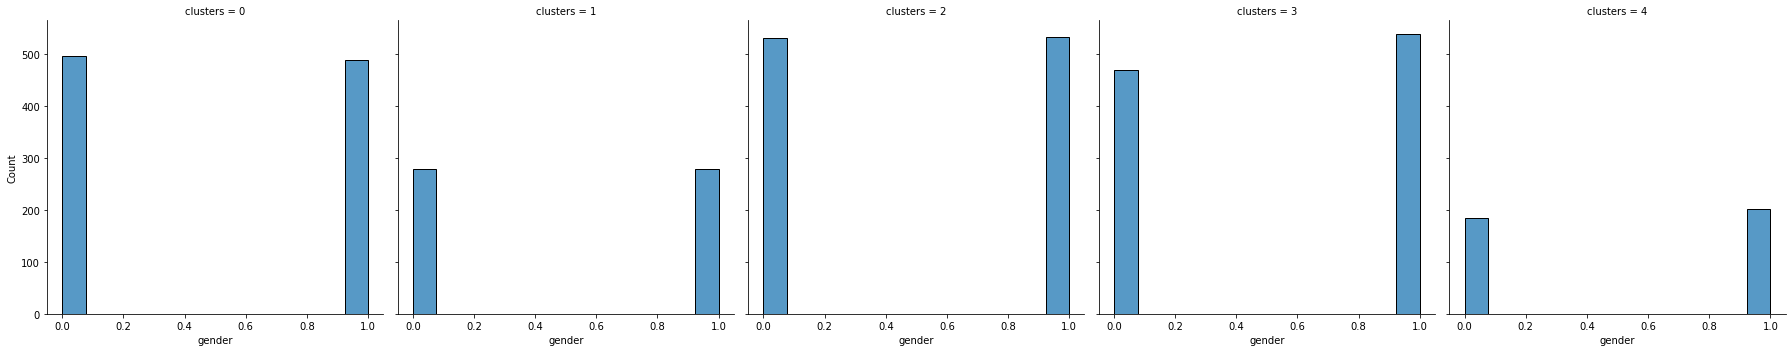

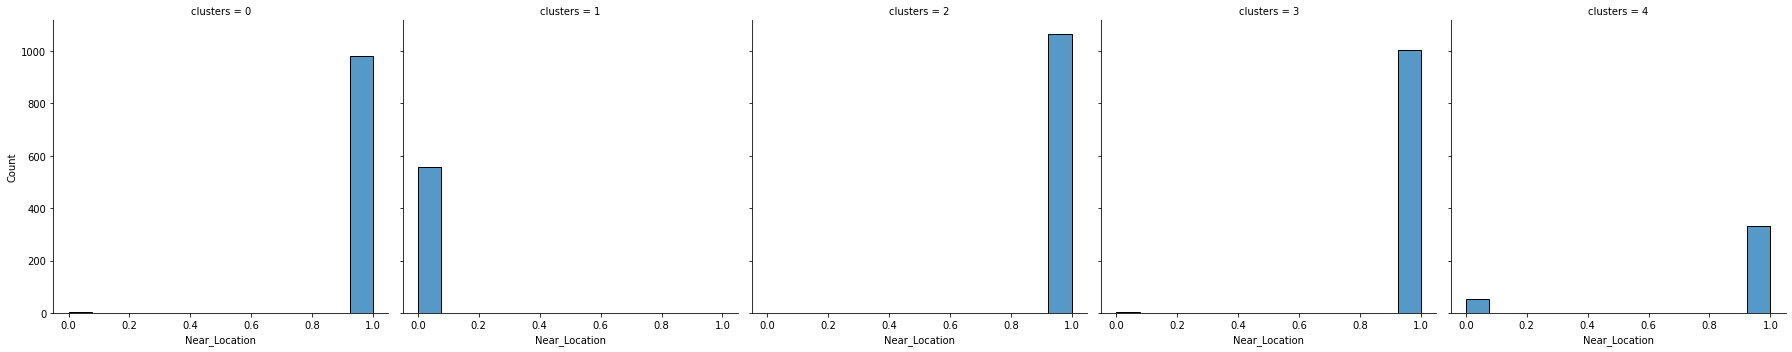

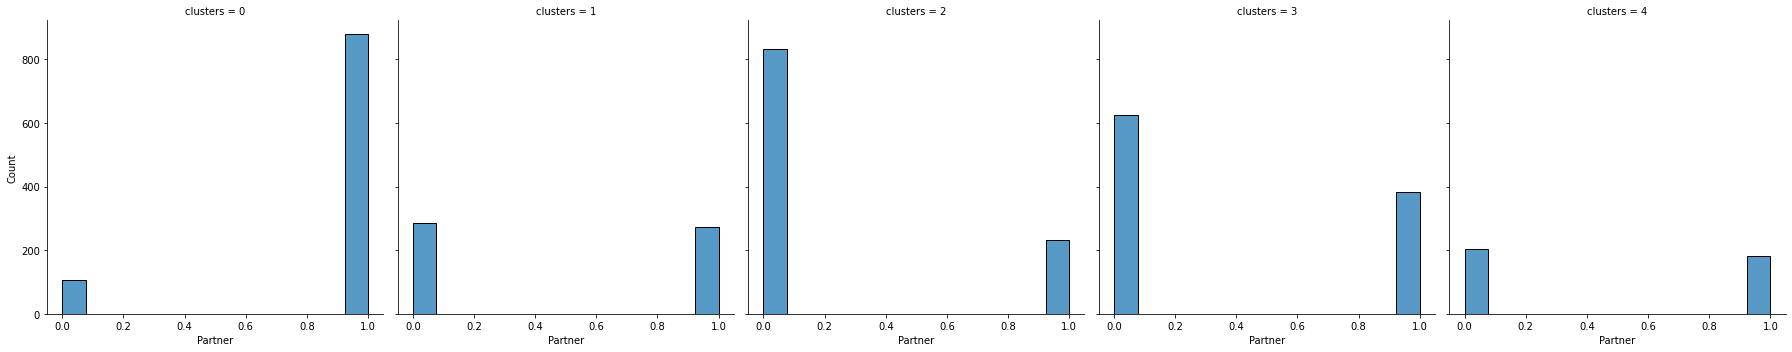

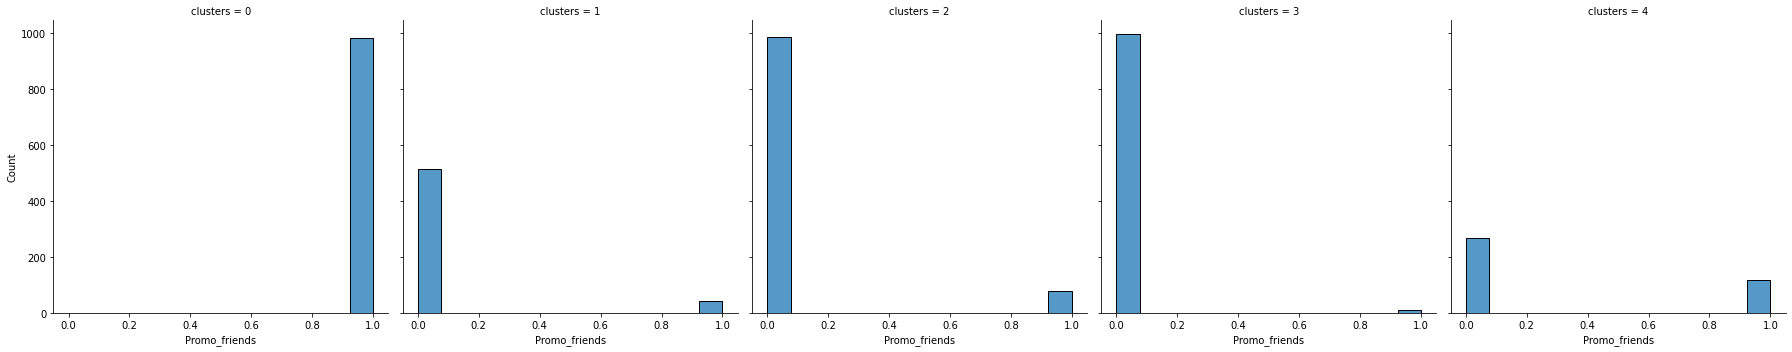

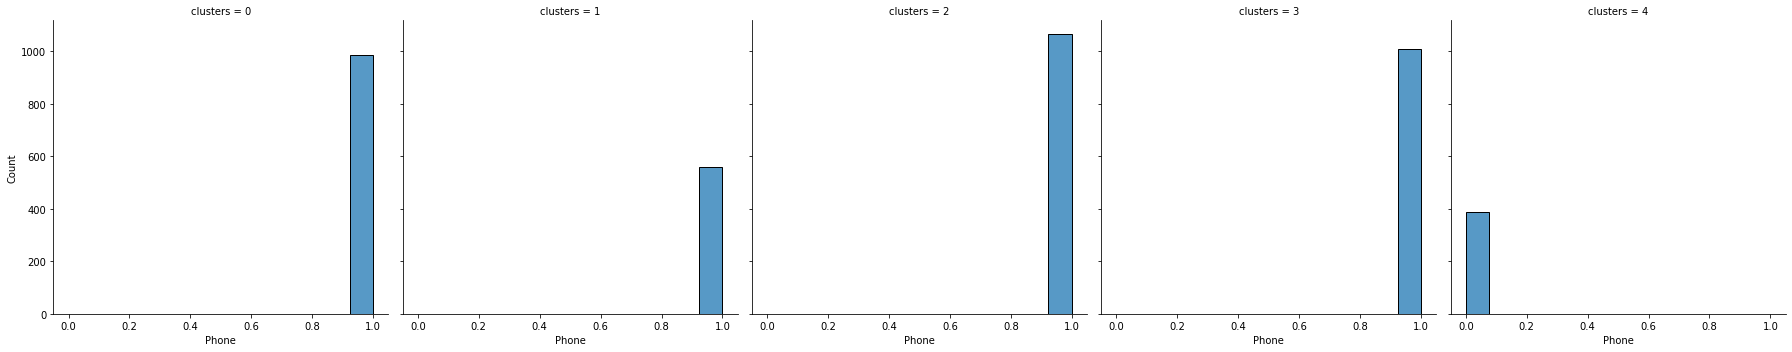

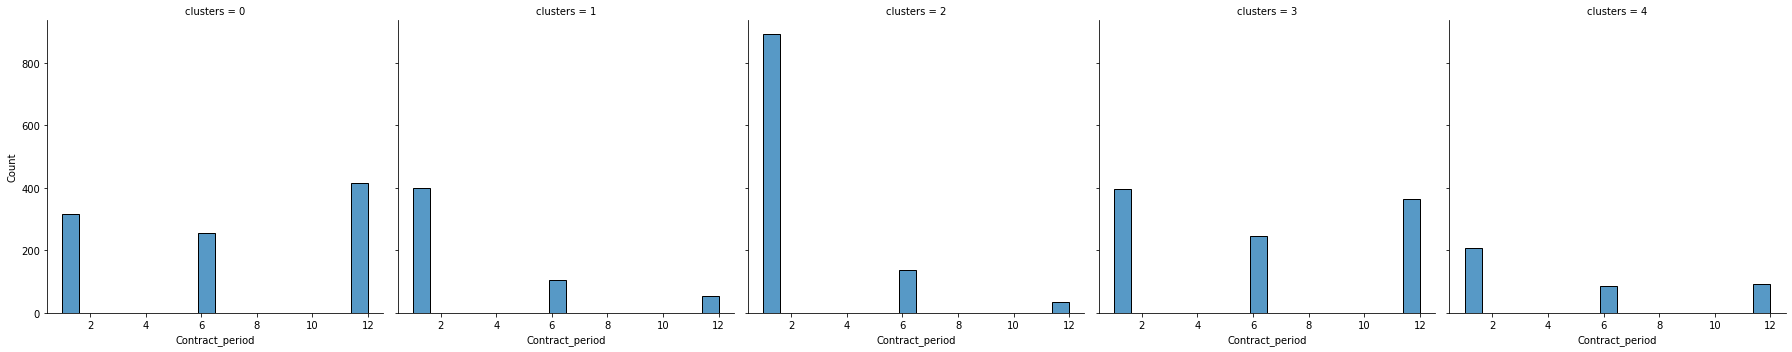

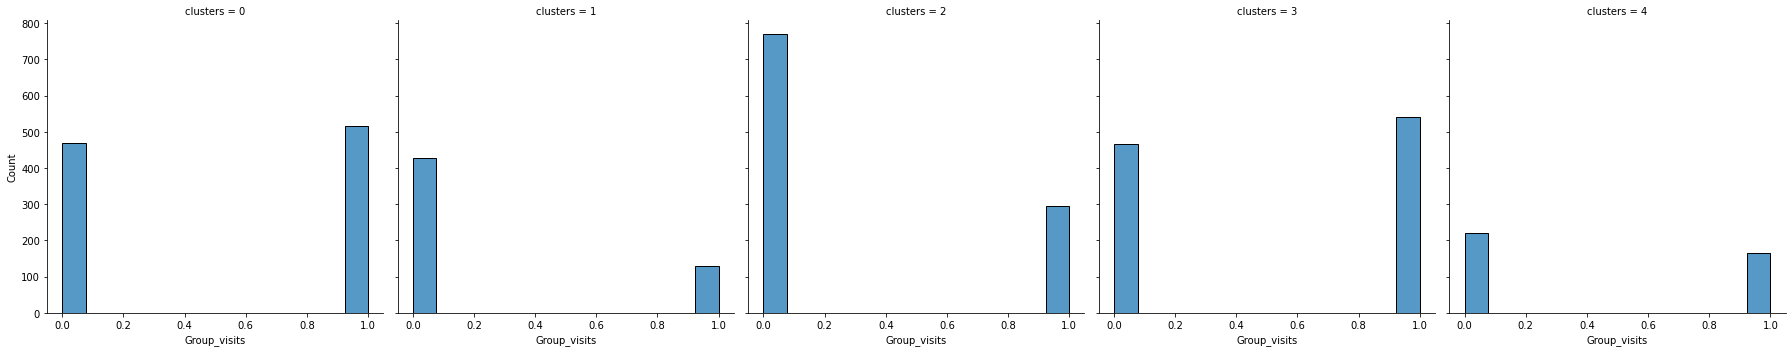

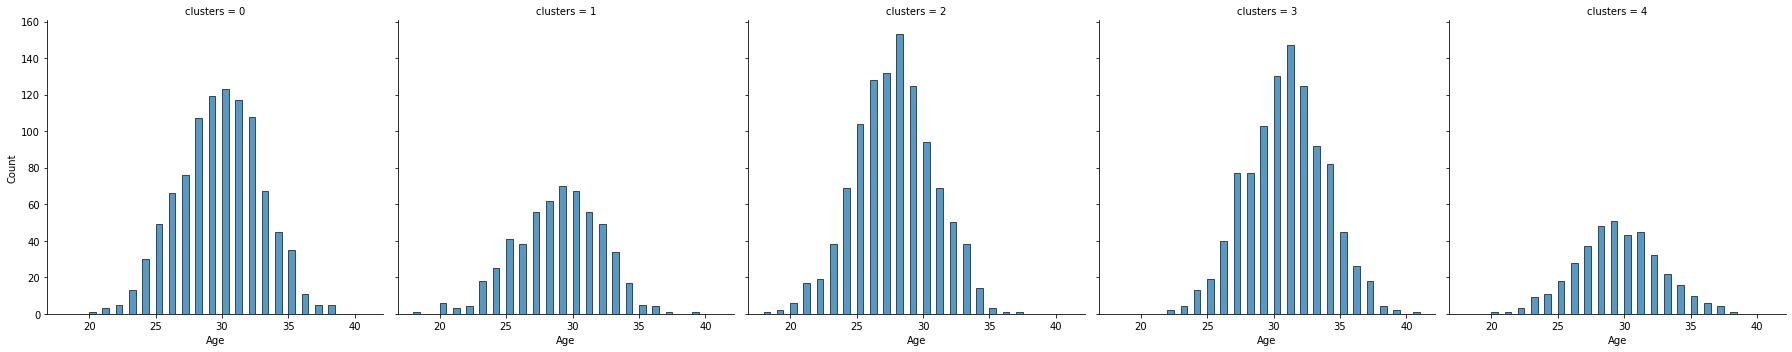

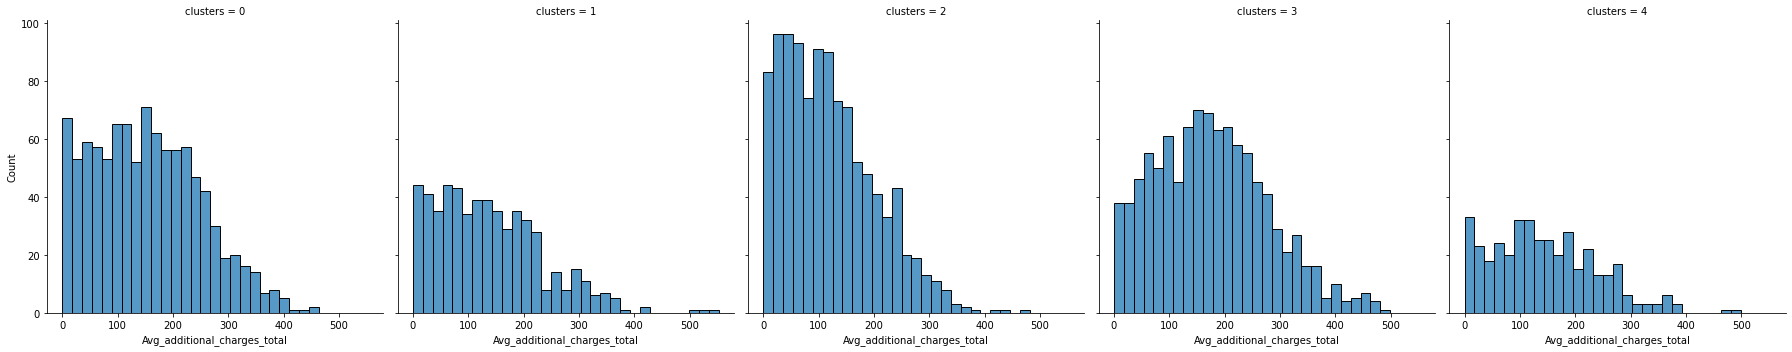

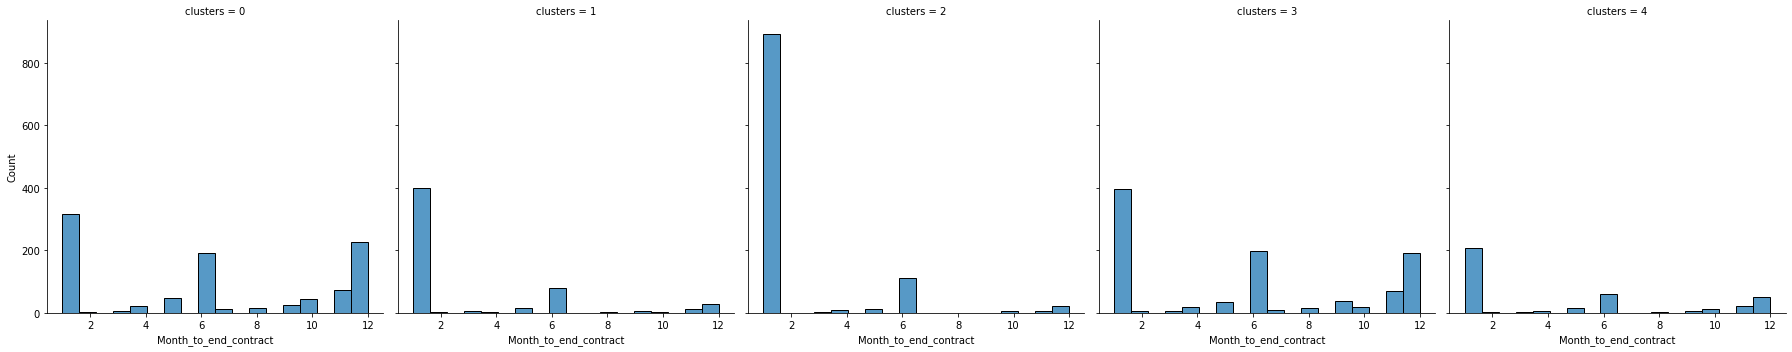

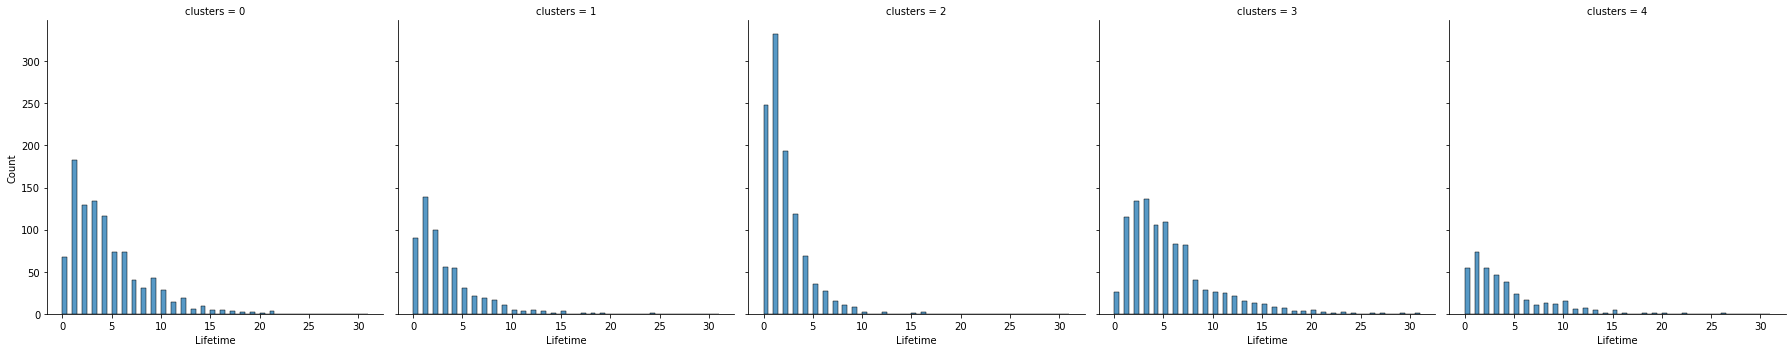

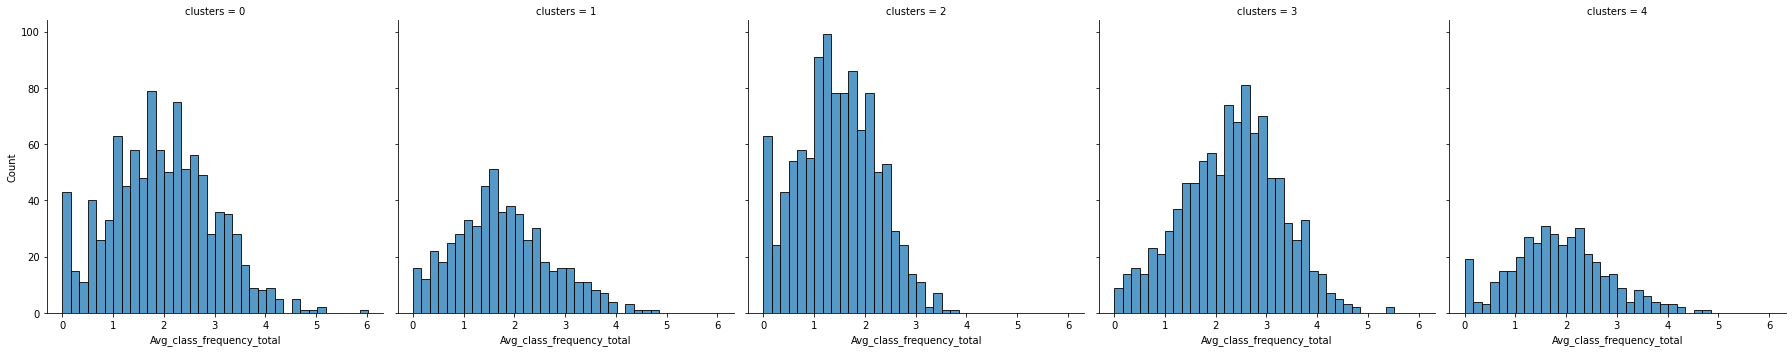

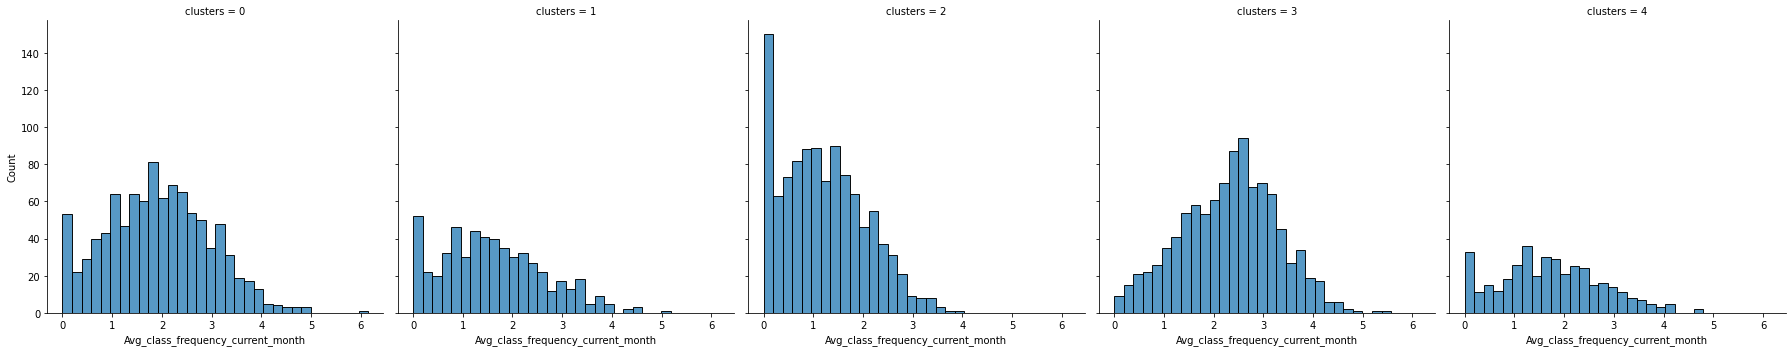

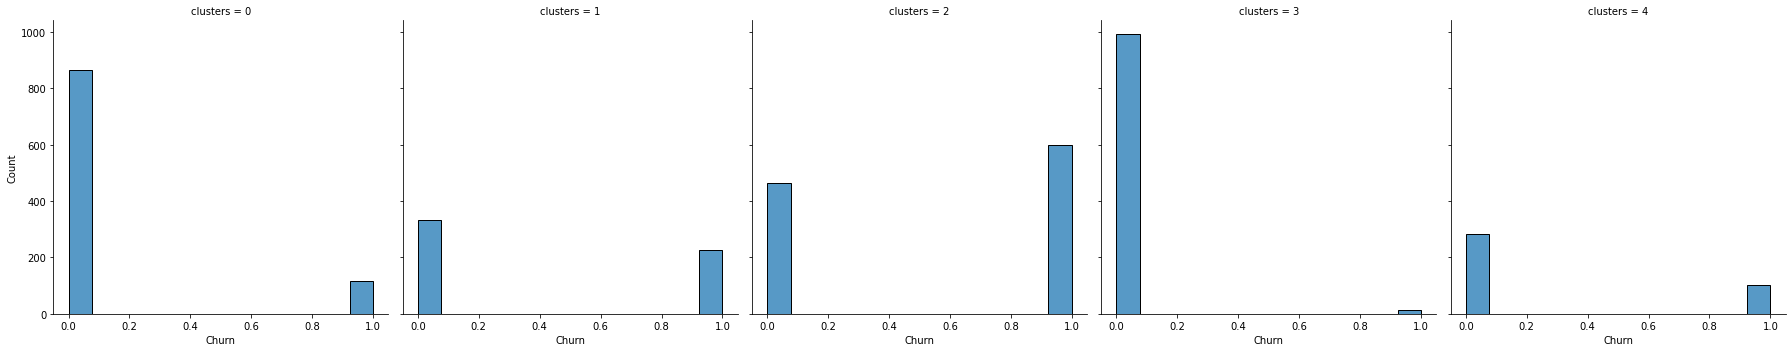

In [22]:
for column in df.drop(['clusters'], axis=1).columns:
    sns.displot(data=df, x=column, col='clusters')
    plt.show()

При изучении распределения признаков в кластерах можно заметить, что в кластерах с самым низким оттоком (0 и 3) распределения таких признаков, как средняя выручка от других услуг фитнес-центра, лайфтайм, среднее число посещений в неделю, стремятся к нормальному. В то время, как распределения аналогичных признаков в кластерах с высоким оттоком (1 и 2) в большей степени смещены влево из-за преобладания низких значений.

### Доля оттока для каждого кластера

In [23]:
df.groupby('clusters').agg({'Churn' : 'mean'}).sort_values(by='Churn') #доля оттока в каждом кластере

,Churn
clusters,
3,0.01
0,0.12
4,0.27
1,0.40
2,0.56


Как уже было показано выше, доля оттока клиентов отличается от кластера к кластеру. Склонны к оттоку клиенты кластеров "1" и "2" (40% и 56% оттока соответственно), а наиболее надежными являются клиенты кластеров "0" и "3" (12% и 1% оттока соответственно). В кластере "4" наблюдается достаточно высокая доля оттока (27%), по сравнению с другими кластерами, показатель оттока в кластере "4" можно назвать промежуточным.

### Промежуточный вывод

1. Выполнили кластеризацию клиентов методом KMeans, в соответствии с техническим заданием было выделено пять кластеров.
2. Наибольшая доля оттока наблюдается среди клиентов "1" и "2" кластера. Данные кластеры характеризуются более низкими показателями среднего возраста клиентов, средней длительности абонементов, выручки от других услуг, частоты посещений фитнес центра в неделю.
3. Самыми надёжными являются клиенты "3" и "0" кластеров. Эти кластеры характеризуют более высокие средний возраст клиентов, длительность абонементов и средние показатели выручки от других услуг фитнес-центра, а также средней частоты посещений фитнес-центра в неделю.  

## Общие выводы

1. Данные использованные для ML, содержат целевую переменную (факт оттока пользователя) и 13 признаков (дубликаты и пропуски в данных отсутствовали).
2. В группе оттока по сравнению с группой оставшихся, преобладают клиенты с абонементом на 1 месяц; ниже доля клиентов проживающих или работающих в районе фитнес-центра, работающих в компании-партнёре, записавшихся в рамках бонусной программы, посещающих групповые занятия; ниже средний возраст, лайфтайм, средняя выручка от других услуг, средняя количество месяцев до окончания абонемента, средние значения средней частоты посещений в неделю за всё время и за последний месяц.
3. Имеется обратная умеренная связь оттока клиентов с длительностью абонемента, количеством месяцев до окончания абонемента, возрастом клиента, лайфтаймом, средней частотой посещений в неделю за последний месяц и за всё время.
4. Имеется слабая обратная связь оттока клиентов с проживанием или работой в районе фитнес-клуба, работой клиента в компании-партнёре, записью в рамках бонусной программы, посещением групповых занятий, средней выручкой от других услуг.
5. Имеется весьма высокая прямая связь количества месяцев до конца абонемента с длительностью абонемента, и средней частоты посещений фитнес-клуба в неделю за весь период со средней частотой посещений фитнес-клуба в неделю за последний месяц.
6. Модель логистической регрессии даёт более точный прогноз оттока клиента с показателями Accuracy, Precision и Recall - 93%, 86% И 83% соответственно.
7. Самый высокий отток наблюдается в кластерах "1" и "2"; они характеризуются более низкими средними показателями среднего возраста клиентов, средней длительности абонементов, выручки от других услуг, частоты посещений фитнес центра в неделю.
8. Самый низкий отток наблюдается в кластерах "3" и "0"ти; они характеризуются более высокими средними показателями среднего возраста клиентов, длительности абонементов, выручки от других услуг фитнес-центра, а также средней частоты посещений фитнес-центра в неделю.  

**Рекомендации для стратегии взаимодействия с клиентами и их удержания**
1. Популяризация приобретения длительных абонементов (6, 12 месяцев). Предоставление скидок и промо-кодов на преобретение длительных абонементов.
2. Стимулирование клиентов к увелечению общего лайфтайма. Предоставление привелегий клиентам фитнес-центра при достижении определенного лайфтайма (скидки на другие услуги, VIP или "золотой" статус, фирменные подарки и т.д.).
3. Поддержание регулярности посещений (частота занятий в неделю) фитнес-центра. Напоминание клиентам о запланированных тренировках, помощь в составлении графика тренировок при преобретении абонемента, длительностью более 1 месяца.
4. Расширение бонусных программ по сторудничеству с компаниями партнёрами, продвижение групповых занятий.
5. Проведение акций по привлечению клиентов более старшего возраста. Скидки на абонементы для клиентов 30+, скидки на групповые занятия для возрастных клиентов.
6. Дополнительные аналитические исследования побочных услуг фитнес-центра, с целью выявления потенциальных точек роста (расширение и совершенствование наиболее популярных у клиентов услуг, что может положительно сказаться на удержании клиентов).